In [3]:
from qick import *
from qick.asm_v2 import *
%matplotlib inline
import matplotlib.pyplot as plt
#This line is to sync to an external clock which needs to be 10 Mhz
#soc = QickSoc(external_clk=True)
soc = QickSoc(bitfile ='/home/xilinx/jupyter_notebooks/qick/qick_lib/qick/qick_216_rfbv2.bit', clk_output=True)
soccfg = soc
print(soccfg)


configuring reference clock chips, as requested
LMK04828 clock reference = 245.760 MHz, LMX2594 clock synth = 491.520 MHz
QICK running on ZCU216, software version 0.2.380

Firmware configuration (built Sat Aug 16 12:14:08 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 1, ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228 on JHC1, or QICK box DAC port 0
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228 on JHC2, or QICK box DAC port 1
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 32768 complex samples (

generator 0 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 0, but it's not multiplexed and doesn't have a mixer, so it will do nothing


  0%|          | 0/1 [00:00<?, ?it/s]

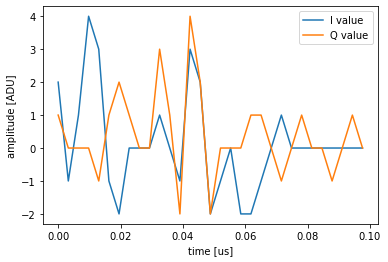

In [8]:
GEN_CH=0 # DAC 
RO_CH=0  # ADC
#BASE WORKABILITY: PLEASE DO NOT CHANGE 
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
        
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 100,
          'freq': 10,
          'nqz': 1,
          'trig_time': 0.4,
          'ro_len': .1,
          'flat_len': .2,
          'ramp_len': 0.01,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']

#external trigger is currently available for tproc_2, on io pin 5, remove start_src if you do not want the trigger

iq_list = prog.acquire_decimated(soc, progress=True, start_src='external')
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [5]:
# attempting to loop a program for several cycles to achieve a continuous signal:
GEN_CH=0 # DAC 
RO_CH=1  # ADC

class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.add_loop("loopedy_loop", 10000000, exec_before=None, exec_after=None)
        
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        #self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)


        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 100,
          'freq': 100,
          'nqz': 1,
          'trig_time': 0.4,
          'ro_len': .1,
          'flat_len': 1,
          'ramp_len': 0.01,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.0, cfg=config)
print(prog)
freq = config['freq']

#external trigger is currently available for tproc_2, on io pin 5, remove start_src if you do not want the trigger
prog.run(soc, start_src='external', progress=True)
#iq_list = prog.acquire_decimated(soc, progress=False, start_src='external')
# t = prog.get_time_axis(ro_index=0)
# iq = iq_list[0]
# plt.plot(t, iq[:,0], label="I value")
# plt.plot(t, iq[:,1], label="Q value")
# plt.legend()
# plt.ylabel("amplitude [ADU]")
# plt.xlabel("time [us]");

generator 0 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 0, but it's not multiplexed and doesn't have a mixer, so it will do nothing


RuntimeError: get_imm_dt: Data Format incorrect #9999999

In [48]:
# attempting to sweep a program for several cycles and achieve a continuous signal:
GEN_CH=0 # DAC 
RO_CH=1  # ADC

class SweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        frequency = QickSweep1D("loopedy_loop", 100, 200)    ####HERE
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=frequency,                      ###HERE
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.add_loop("loopedy_loop", 100000, exec_before=None, exec_after=None)
        
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t = 0)
        #self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)


        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 100,
          'freq': 100,
          'nqz': 1,
          'trig_time': 0.4,
          'ro_len': .1,
          'flat_len': 1,
          'ramp_len': 0.01,
          'phase': 0,
          'gain': 1.0
         }

prog = SweepProgram(soccfg, reps=1, final_delay=0.0, cfg=config)
print(prog)
freq = config['freq']

#external trigger is currently available for tproc_2, on io pin 5, remove start_src if you do not want the trigger
prog.acquire_decimated(soc, progress=True, start_src='external')

generator 0 doesn't have a digital mixer, but mixer_freq was defined
ro_ch was defined for generator 0, but it's not multiplexed and doesn't have a mixer, so it will do nothing


macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(auto=True, gens=True, ros=True, t=1.0, t_params={'t': <qick.asm_v2.QickParam object at 0xffff5f684280>}, t_regs={'t': 430}, tag=None)
	OpenLoop(n=1, name='reps')
	OpenLoop(n=100000, name='loopedy_loop')
	Pulse(ch=0, name='mypulse', t=0, t_params={'t': <qick.asm_v2.QickParam object at 0xffff5f684160>}, t_regs={'t': 0}, tag=None)
	Wait(auto=True, gens=False, no_warn=True, ros=True, t=0, t_params={'t': <qick.asm_v2.QickParam object at 0xffff5f684d30>}, t_regs={'t': 0}, tag=None)
	Delay(auto=True, gens=True, ros=True, t=0.0, t_params={'t': <qick.asm_v2.QickParam object at 0xffff5f684700>}, t_regs={'t': 430}, tag=None)
	IncReg(dst='s_core_w1', src=1)
	CloseLoop()
	CloseLoop()
	End()
registers:
	reps: QickRegisterV2(addr=0, init=None)
	loopedy_loop: QickRegisterV2(addr=1, init=None)
	scratch: QickRegisterV2(addr=2, init=None)
pulses:
	mypulse: QickPulse(waveforms=[Waveform(name='mypulse_w0', freq=QickRawParam(par='freq', start=44810940, spans=

  0%|          | 0/1 [00:00<?, ?it/s]

[]

In [290]:
GEN_CH=0 # DAC 
RO_CH=10  # ADC
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['adc_freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['dac_freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
        
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['ro_len']+cfg['trig_time']+cfg['down_time'])

        
        
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'dac_freq': 120,
          'adc_freq': 110,
          'nqz': 1,
          'trig_time': 0.5,
          'ro_len': 0.004,
          'down_time':0.0059,
          'flat_len': .4,
          'ramp_len': 0.01,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)


#external trigger is currently available for tproc_2, on io pin 5, remove start_src if you do not want the trigger
exp_pnts = prog.acquire(soc, progress=True)
rounds = prog.get_rounds()
t = prog.get_time_axis(ro_index=0)




ro_ch was defined for generator 0, but it's not multiplexed and doesn't have a mixer, so it will do nothing


  0%|          | 0/1 [00:00<?, ?it/s]

In [117]:
avg_arctan = (np.arctan2(-6, 1) - np.arctan2(-1, 1))/2
arctann = np.arctan2(-1,1)
print(avg_arctan, arctann)
def fast_atan(a, b=1):
    if b == 0:
        return 1.57079633
    else:
        x= a/b
        a = [0.994766756708199, -2.8543851807526100E-01, 0.0760699247645105]
        xx = x * x;
        return ((a[2] * xx + a[1]) * xx + a[0]) * x;


def phase_direction():
    self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
    self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['ro_len']+cfg['trig_time']+cfg['down_time'])
    

-0.3101247429914108 -0.7853981633974483


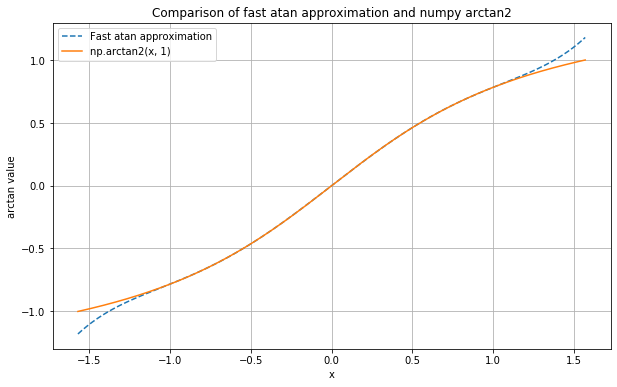

In [128]:
x_coordinates = np.linspace(-math.pi/2, math.pi/2, 500)
fast_arctan = np.zeros(len(x_coordinates))
for i, value in enumerate(x_coordinates):
    fast_arctan[i]=fast_atan(value)
normal_arctan = np.arctan2(x_coordinates, 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_coordinates, fast_arctan, label='Fast atan approximation', linestyle='--')
plt.plot(x_coordinates, normal_arctan, label='np.arctan2(x, 1)', linestyle='-')
plt.xlabel('x')
plt.ylabel('arctan value')
plt.title('Comparison of fast atan approximation and numpy arctan2')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

min_val, max_val = -3000, 3000
min_idx_i, max_idx_i = 6000, 0
min_idx_q, max_idx_q = 6000, 0
grid_size = max_val - min_val + 1

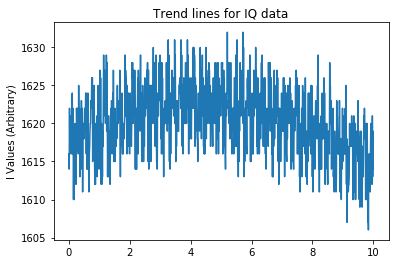

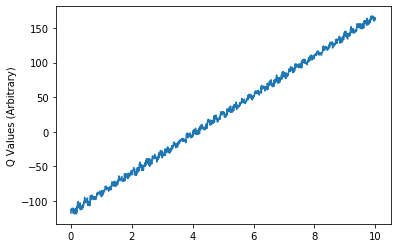

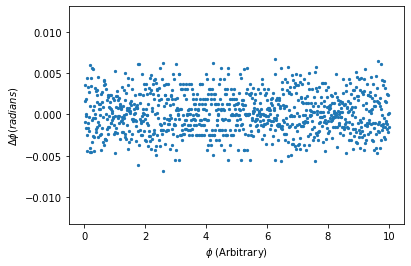

In [244]:
heatmap_data = np.zeros((grid_size, grid_size), dtype=np.float64)
heatmap_data_fast = np.zeros((grid_size, grid_size), dtype=np.float64)
GEN_CH=0 # DAC 
RO_CH=10  # ADC
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        phase = QickSweep1D("loopedy_loop", 0, 10)    ####HERE

        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['adc_freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['dac_freq'],
                       length=cfg['flat_len'],
                       phase=phase,
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.add_loop("loopedy_loop", 1000, exec_before=None, exec_after=None)



    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['ro_len']+cfg['trig_time']+cfg['down_time'])




config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'dac_freq': 110,
          'adc_freq': 110,
          'nqz': 1,
          'trig_time': 0.5,
          'ro_len': 0.004,
          'down_time':0.0059,
          'flat_len': .4,
          'ramp_len': 0.01,
          'phase': .875,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay = 0.1, cfg=config)


#external trigger is currently available for tproc_2, on io pin 5, remove start_src if you do not want the trigger
exp_pnts = prog.acquire(soc, progress = False)
rounds = prog.get_rounds()
t = prog.get_time_axis(ro_index=0)
data = rounds[0][0][0]
x = np.linspace(0,10,len(data))
y = data[:, 0]
z = data[:, 1]
plt.figure()
plt.plot(x, y, label='y data')
plt.title('Trend lines for IQ data')
plt.ylabel('I Values (Arbitrary)')

plt.figure()
plt.plot(x, z)
plt.ylabel('Q Values (Arbitrary)')

plt.figure()
plt.scatter(x[1:], np.diff(np.arctan2(z,y)), s=5)
plt.xlabel('$\phi$ (Arbitrary)')
plt.ylabel('$\Delta\phi (radians)$' )
plt.show()


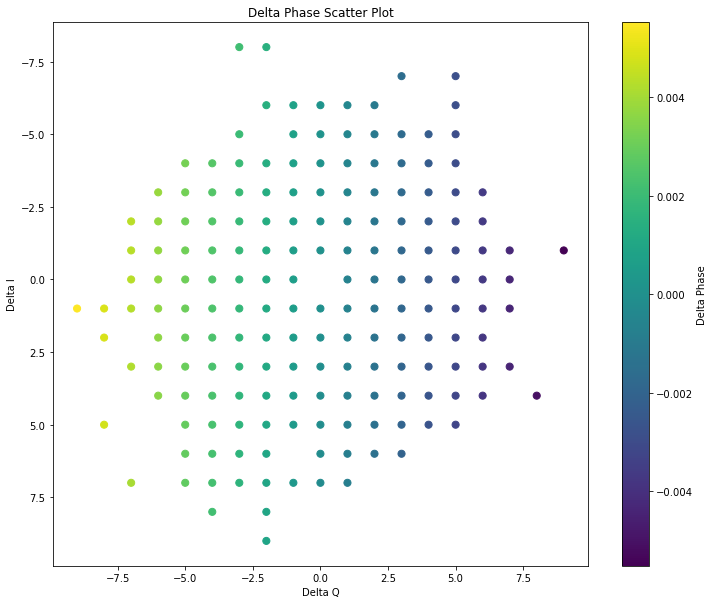

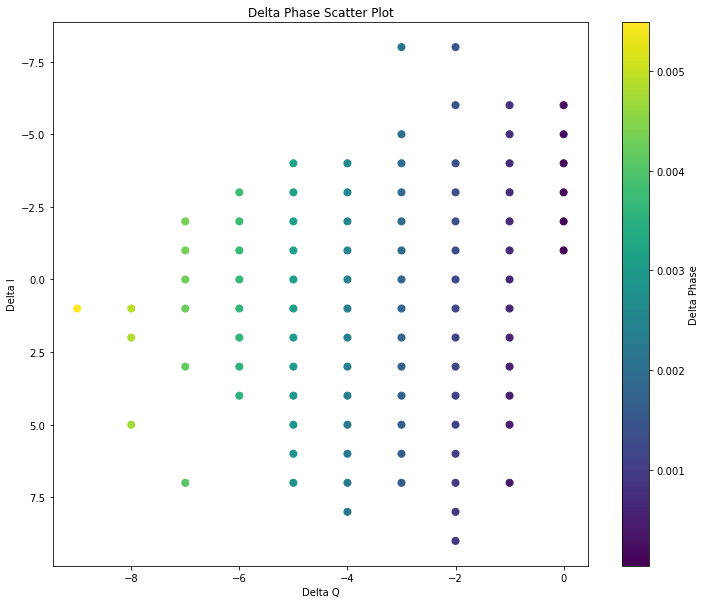

In [175]:
valid_points = ~np.isnan(heatmap_data)
y_coords, x_coords = np.where(valid_points)
values = heatmap_data[valid_points]

plt.figure(figsize=(12,10))
scatter = plt.scatter(x_coords-3000, y_coords-3000, c=values, s=50, cmap='viridis')  # s controls size
plt.colorbar(scatter, label='Delta Phase')
plt.gca().invert_yaxis()  # To match imshow orientation if needed
plt.title('Delta Phase Scatter Plot')
plt.xlabel('Delta Q')
plt.ylabel('Delta I')

valid_points = ~np.isnan(heatmap_data_fast)
y_coords, x_coords = np.where(valid_points)
values = heatmap_data_fast[valid_points]

plt.figure(figsize=(12,10))
scatter = plt.scatter(x_coords[values > 0]-3000, y_coords[values > 0]-3000, c=values[values>0], s=50, cmap='viridis')  # s controls size
plt.colorbar(scatter, label='Delta Phase')
plt.gca().invert_yaxis()  # To match imshow orientation if needed
plt.title('Delta Phase Scatter Plot')
plt.xlabel('Delta Q')
plt.ylabel('Delta I')

plt.show()

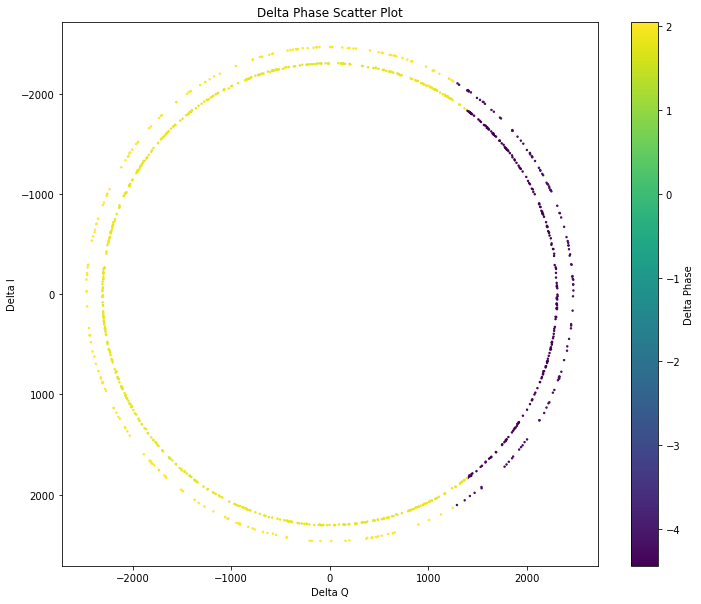

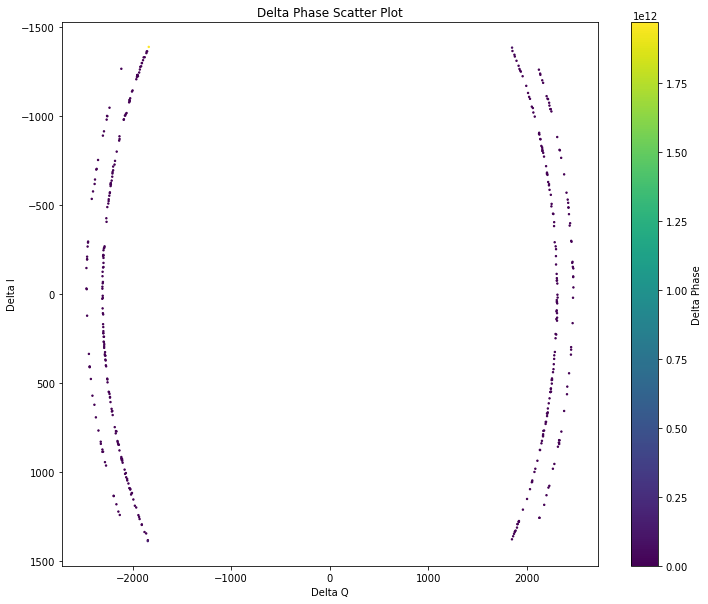

In [126]:
valid_points = ~np.isnan(heatmap_data)
y_coords, x_coords = np.where(valid_points)
values = heatmap_data[valid_points]

plt.figure(figsize=(12,10))
scatter = plt.scatter(x_coords-3000, y_coords-3000, c=values, s=2, cmap='viridis')  # s controls size
plt.colorbar(scatter, label='Delta Phase')
plt.gca().invert_yaxis()  # To match imshow orientation if needed
plt.title('Delta Phase Scatter Plot')
plt.xlabel('Delta Q')
plt.ylabel('Delta I')

valid_points = ~np.isnan(heatmap_data_fast)
y_coords, x_coords = np.where(valid_points)
values = heatmap_data_fast[valid_points]

plt.figure(figsize=(12,10))
scatter = plt.scatter(x_coords[values > 0]-3000, y_coords[values > 0]-3000, c=values[values>0], s=2, cmap='viridis')  # s controls size
plt.colorbar(scatter, label='Delta Phase')
plt.gca().invert_yaxis()  # To match imshow orientation if needed
plt.title('Delta Phase Scatter Plot')
plt.xlabel('Delta Q')
plt.ylabel('Delta I')

plt.show()

In [54]:
#From here on out the hardware has been changed. Be warned!!
from qick import *
from qick.asm_v2 import *
%matplotlib inline
import matplotlib.pyplot as plt
#This line is to sync to an external clock which needs to be 10 Mhz
#soc = QickSoc(external_clk=True)
soc = QickSoc(bitfile ='/home/xilinx/jupyter_notebooks/qick/qick_lib/qick/d_1.bit', clk_output=True)
soccfg = soc
print(soccfg)


configuring reference clock chips, as requested
LMK04828 clock reference = 245.760 MHz, LMX2594 clock synth = 491.520 MHz


RuntimeError: tracing port m0_axis from block axis_avg_buffer_10: expected to find axi_dma or axis_switch, found cordic instead

In [52]:
# attempting to sweep a program for several cycles and achieve a continuous signal:
GEN_CH=0 # DAC 
RO_CH=0  # ADC

class SweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):

        frequency = QickSweep1D("loopedy_loop", 100, 200)    ####HERE
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['adc_freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=frequency,                      ###HERE
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.add_reg("my_reg")
        self.add_loop("loopedy_loop", 100000, exec_before=None, exec_after=None)
        
        
    def _body(self, cfg):
        reg = QickRegisterV2("my_reg")
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.read_input(ro_ch = cfg['ro_ch'])
        self.write_dmem("r1", 's_port_h')
        self.write_dmem("r2", 's_port_l')
        reg.read_dmem("r1")
        #for channel 0 the tproc saves it in tproc input 0
        

        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'dac_freq': 110,
          'adc_freq': 110,
          'nqz': 1,
          'trig_time': 0.5,
          'ro_len': 0.004,
          'down_time':0.0059,
          'flat_len': .4,
          'ramp_len': 0.01,
          'phase': .875,
          'gain': 1.0
         }

prog = SweepProgram(soccfg, reps=1, final_delay=0.0, cfg=config)
print(prog)

#external trigger is currently available for tproc_2, on io pin 5, remove start_src if you do not want the trigger
prog.run(soc, start_src='external')
print("wmem:")
print(soccfg.read_mem(mem_sel = "wmem", length=1, addr=0))
print(soccfg.read_mem(mem_sel = "wmem", length=1, addr=1))
print(soccfg.read_mem(mem_sel = "wmem", length=1, addr=2))
print("dmem:")
print(soccfg.read_mem(mem_sel = "dmem", length=1, addr=0))
print(soccfg.read_mem(mem_sel = "dmem", length=1, addr=1))
print(soccfg.read_mem(mem_sel = "dmem", length=1, addr=2))

ro_ch was defined for generator 0, but it's not multiplexed and doesn't have a mixer, so it will do nothing


AttributeError: 'QickRegisterV2' object has no attribute 'read_dmem'